In [1]:
import re
import os
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(context='notebook', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
new_gapn_data_file = "data/20211018-GapN-data-up-to-SM160.csv"
df = pd.read_csv(new_gapn_data_file, index_col=0)
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
df['Sequence'] = df['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))
wt_seq = df.loc['WT']['Sequence']
wt_nadp = df.loc['WT']['NADP+_initial_rate']
df = df.dropna()
df.tail(2)

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate
pSM159,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,P178A + T179Q + G209V + I233T,16.56,21.205556
pSM160,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,P178A + T179Q + G209V + I233V,32.06,23.254444


In [4]:
# convert the nad+ initial rate to % WT activity
df['NAD+_initial_rate'] = df['NAD+_initial_rate'] / wt_nadp * 100
df.tail(2)

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate
pSM159,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,P178A + T179Q + G209V + I233T,40.055902,21.205556
pSM160,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,P178A + T179Q + G209V + I233V,77.547839,23.254444


In [5]:
# extract the mutations for each sequence
seq_mutations = df['WT_mutations'].apply(lambda x: [mut.strip() for mut in x.split(' + ')])
seq_mutations.head(2)

pSM038           [G209V]
pSM050    [K176F, S210E]
Name: WT_mutations, dtype: object

In [6]:
# make sure the mutations match
seq_list = df.Sequence.apply(list).apply(np.asarray)
wt_seq = np.asarray(list(wt_seq))
mutations = seq_list.apply(lambda x: [f"{wt_seq[i]}{i}{x[i]}" for i in np.where(wt_seq != x)[0]])
df['mutation_from_seq'] = mutations.apply(set)
df['mutation_from_annot'] = df.WT_mutations.fillna('').str.split(' \+ ')\
    .apply(lambda x: [xi.strip().rstrip() for xi in x]).apply(set)

In [7]:
df[df.mutation_from_seq != df.mutation_from_annot].iloc[:, -2:]

,mutation_from_seq,mutation_from_annot


In [8]:
# load the embeddings
# /projects/bpms/jlaw/gapn-engineering/embeddings/20211018_esm1b_t33_650M_UR50S_gapnSM160_residue_embeddings.npz
embed_file = 'embeddings/20220210_esm_msa1b_gapnSM160_residue_embeddings.npz'
embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
wt_embedding = embeddings[0]
embeddings = embeddings[1:]

In [9]:
embeddings.shape

(95, 475, 768)

In [25]:
out_dir = "viz/20220210_esm_msa1b"

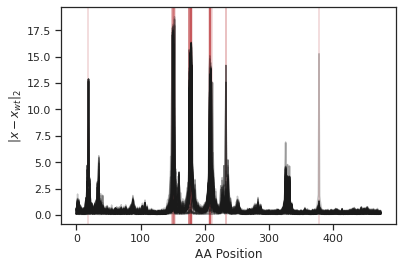

In [12]:
# compare the embeddings with the WT embedding
relative_embeddings = embeddings - wt_embedding
relative_mean_embeddings = relative_embeddings[:, 1:, :].mean(1)
# mean_embeddings = embeddings_valid[:, 1:, :].mean(1)

_ = plt.plot(np.linalg.norm(relative_embeddings, axis=-1).T, color='k', alpha=.25)
for x in list(set.union(*df.mutation_from_seq)):
    plt.axvline(int(re.findall('\d+', x)[0]), color='r', alpha=0.25, zorder=0)

plt.xlabel('AA Position')
plt.ylabel(r'$| x - x_{wt} |_2$')

plt.savefig(f"out_dir/embeddings_vs_wt.png", dpi=300)

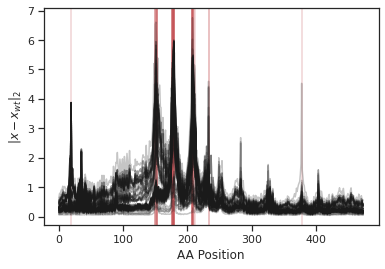

In [210]:
# compare the embeddings with the WT embedding
relative_embeddings = embeddings - wt_embedding
relative_mean_embeddings = relative_embeddings[:, 1:, :].mean(1)
# mean_embeddings = embeddings_valid[:, 1:, :].mean(1)

_ = plt.plot(np.linalg.norm(relative_embeddings, axis=-1).T, color='k', alpha=.25)
for x in list(set.union(*df.mutation_from_seq)):
    plt.axvline(int(re.findall('\d+', x)[0]), color='r', alpha=0.25, zorder=0)

plt.xlabel('AA Position')
plt.ylabel(r'$| x - x_{wt} |_2$')

plt.savefig("embeddings_vs_wt.png", dpi=300)

In [58]:
# Generate per-sequence representations via averaging
representations = [x.mean(0) for x in embeddings]
representations = np.vstack(representations)

/lustre/eaglefs/projects/deepgreen/jlaw/envs/fairseq/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
representations.shape

(95, 768)

In [ ]:
!pip install pytorch_lightning

In [14]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [43]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.ReLU(),
            # nn.Linear(512, 1),            
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            # nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [44]:
def fit_predict(X_train, y_train, X_valid):
    pl.seed_everything(42)
    model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        gpus=-1,
        max_steps=400,
        log_every_n_steps=4,
        progress_bar_refresh_rate=0.)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model(torch.Tensor(X_valid)).detach().numpy()

In [52]:
import itertools
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVR
# Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick.
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
# "The form of the model learned by KRR is identical to support vector regression (SVR). 
# However, different loss functions are used: 
# KRR uses squared error loss while support vector regression uses epsilon-insensitive loss, 
# both combined with l2 regularization. In contrast to SVR, fitting a KRR model can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for epsilon > 0, at prediction-time.
from sklearn.kernel_ridge import KernelRidge

# alg = "svr"
# alg = 'krr'
# kernel = 'laplacian'
alg = 'ridge'


# model_name = "esm1b_t33_650M_UR50S"
model_name = "esm_msa1b_t12_100M_UR50S"
X = representations
y = df['NAD+_initial_rate'].astype(float)
# take the exponent of the training data and predicted probabilities so nothing is < 0

y_train_test = y
# normalize_vals = False
# wt_nadph = 41.342
# log_transform = False
# if normalize_vals:
#     y_train_test = np.asarray([max(0,x/wt_nadph) for x in y])
# if log_transform:
#     y_train_test = np.asarray([np.log(max(1,x)) for x in y])

## Try time-based evaluation

In [19]:
gapn_batches_df = pd.read_csv("data/gapn-batches.csv")
gapn_batches_df.head(2)

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Unnamed: 7
0,pSM038,pSM068,pSM078,pSM113,pSM121,pSM140,pSM214,SmGapN I19F + P178A + T179Q + G209V + I233T
1,pSM050,pSM069,pSM079,pSM114,pSM122,pSM141,pSM215,SmGapN I19F + P178A + T179Q + G209V + I233V


In [20]:
gapn_batches = {}
# batch 7 isn't done yet, so skip for now
for batch in range(1,7):
    gapn_batches[batch] = gapn_batches_df[f'Batch {batch}'].dropna().values
    print(f"{len(gapn_batches[batch])} seqs in batch {batch}")
# also build the flipped to add to df
seq_batch = {s: batch for batch, seqs in gapn_batches.items() for s in seqs}

15 seqs in batch 1
8 seqs in batch 2
35 seqs in batch 3
6 seqs in batch 4
10 seqs in batch 5
21 seqs in batch 6


In [21]:
# another form of validation is if we do a batch-based split i.e., try to predict the activity of the next batch
train_test_splits = []
size_test = []
for i in range(1,6):
    train_seqs = []
    for j in range(1,i+1):
        train_seqs += list(gapn_batches[j])
    test_seqs = gapn_batches[i+1]
    train_idx = np.arange(len(train_seqs))
    test_idx = np.arange(len(test_seqs)) + len(train_seqs)
    train_test_splits.append((train_idx, test_idx))

In [39]:
alg = 'nn'
X = relative_mean_embeddings
y = df['NAD+_initial_rate'].values.reshape(-1, 1)

In [53]:
# this block uses mutation-based splits
if alg in ['krr', 'ridge']:
#     alphas = [10**x for x in np.arange(-6,5).astype(float)]
    alphas = [.0001]
else:
    alphas = [None]
best_alpha = 0
best_rmse = 10000
best_y_pred = []
# print("model_name\talpha\tgamma\tavg_slope\tavg_mae\tavg_rmse")
print("model_name\talpha\tavg_slope\tavg_mae\tavg_rmse")
# for alpha, gamma in itertools.product(alphas, gammas):
for alpha in alphas:
    y_preds = []
    maes = []
    rmses = []
    slopes = []

    # initialize with numpy nans that shouldn't be included in the plot if they 
    y_pred = np.empty(len(y))
    y_pred[:] = np.nan
    for train_idx, test_idx in train_test_splits:
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if alg == 'krr':
            clf = KernelRidge(alpha=alpha, kernel=kernel)
            clf.fit(X_train, y_train)
            y_pred[test_idx] = clf.predict(X_test)
        elif alg == "ridge":
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred[test_idx] = clf.predict(X_test)
        elif alg == 'nn':
            y_pred[test_idx] = fit_predict(X_train, y_train, X_test).flatten()

    y_preds.append(y_pred)
    # mean avg error
    mae = np.sum(np.abs(y_train_test - y_pred))
    # also compute the root mean squared error
    rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
    maes.append(mae)
    rmses.append(rmse)
    # and the slope
    slope, intercept, r_value, p_value, std_err = linregress(y_train_test, y_pred)
    slopes.append(slope)

    avg_mae = np.mean(mae)
    avg_slope = np.mean(slopes)
    avg_rmse = np.mean(rmses)
    print(f"{model_name}\t{alpha}\t{avg_slope:0.2f}\t{avg_mae:0.2f}\t{avg_rmse:0.2f}")

    if avg_rmse < best_rmse + 0.01:
#     if avg_rmse < best_rmse:
        best_rmse = avg_rmse
#         best_alpha = (alpha, gamma)
        best_alpha = alpha
        best_y_pred = y_pred
y_pred = best_y_pred
print(f"best_rmse: {best_rmse:0.2f}, best_alpha: {str(best_alpha)}")

model_name	alpha	avg_slope	avg_mae	avg_rmse
esm_msa1b_t12_100M_UR50S	0.0001	nan	1358.13	26.03
best_rmse: 26.03, best_alpha: 0.0001


In [240]:
# this block uses mutation-based splits
if alg in ['krr', 'ridge']:
    alphas = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10]
#     alphas = [.0001]
else:
    alphas = [None]
best_alpha = 0
best_rmse = 10000
best_y_pred = []
# print("model_name\talpha\tgamma\tavg_slope\tavg_mae\tavg_rmse")
print("model_name\talpha\tavg_slope\tavg_mae\tavg_rmse")
# for alpha, gamma in itertools.product(alphas, gammas):
for alpha in alphas:
    y_preds = []
    maes = []
    rmses = []
    slopes = []

    # initialize with numpy nans that shouldn't be included in the plot if they 
    y_pred = np.empty(len(y))
    y_pred[:] = np.nan
    for train_idx, test_idx in train_test_splits:
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if alg == 'krr':
            clf = KernelRidge(alpha=alpha, kernel=kernel)
            clf.fit(X_train, y_train)
            y_pred[test_idx] = clf.predict(X_test)
        elif alg == "ridge":
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred[test_idx] = clf.predict(X_test)
        elif alg == 'nn':
            y_pred[test_idx] = fit_predict(X_train, y_train, X_test).flatten()

    y_preds.append(y_pred)
    # mean avg error
    mae = np.sum(np.abs(y_train_test - y_pred))
    # also compute the root mean squared error
    rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
    maes.append(mae)
    rmses.append(rmse)
    # and the slope
    slope, intercept, r_value, p_value, std_err = linregress(y_train_test, y_pred)
    slopes.append(slope)

    avg_mae = np.mean(mae)
    avg_slope = np.mean(slopes)
    avg_rmse = np.mean(rmses)
    print(f"{model_name}\t{alpha}\t{avg_slope:0.2f}\t{avg_mae:0.2f}\t{avg_rmse:0.2f}")

    if avg_rmse < best_rmse + 0.01:
#     if avg_rmse < best_rmse:
        best_rmse = avg_rmse
#         best_alpha = (alpha, gamma)
        best_alpha = alpha
        best_y_pred = y_pred
y_pred = best_y_pred
print(f"best_rmse: {best_rmse:0.2f}, best_alpha: {str(best_alpha)}")

model_name	alpha	avg_slope	avg_mae	avg_rmse
esm1b_t33_650M_UR50S	1e-06	nan	595.88	11.74
esm1b_t33_650M_UR50S	1e-05	nan	596.43	11.75
esm1b_t33_650M_UR50S	0.0001	nan	601.60	11.83
esm1b_t33_650M_UR50S	0.001	nan	634.10	12.42
esm1b_t33_650M_UR50S	0.01	nan	692.63	13.94
esm1b_t33_650M_UR50S	0.1	nan	738.15	15.30
esm1b_t33_650M_UR50S	1	nan	757.54	15.70
esm1b_t33_650M_UR50S	10	nan	754.20	15.87
best_rmse: 11.75, best_alpha: 1e-05


In [23]:
# add the # training examples in parenthesis (e.g., batch 2 has 15 training examples)
batch_series = pd.Series({s: f"{b} ({len([s2 for i in range(1,b) for s2 in gapn_batches[i]])})" for s, b in seq_batch.items()})

In [54]:
# if log_transform:
#     y_preds = [np.exp(ys) for ys in y_preds]
#     df2 = pd.DataFrame({'y': np.exp(y_train_test), 'y_pred': np.mean(y_preds, axis=0)})
if alg == 'nn':
    y = y.flatten()
df2 = pd.DataFrame({'y': y, 'y_pred': y_pred, 
                    'Batch (# train)': batch_series}
                  ).dropna()
df2.head(2)

,y,y_pred,Batch (# train)
pSM068,0.040322,-0.308542,2 (15)
pSM069,0.000000,0.199533,2 (15)


viz/20220210_esm_msa1b/batch-eval-gapn-nadh-ridge-esm_msa1b_t12_100M_UR50S-a0.0001.svg


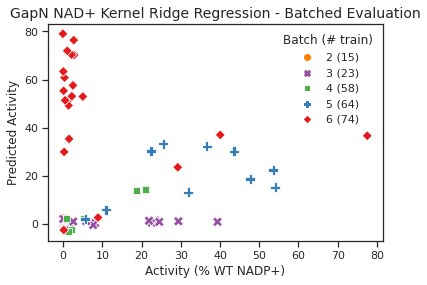

In [55]:
f, ax = plt.subplots()
# color = "#3291a8"
# df2.plot.scatter(x='y', y="y_pred", color=color, ax=ax)
palette = sns.color_palette('Set1')[:df2['Batch (# train)'].nunique()][::-1]
markers = ['<','o','x','+','s','*']
sns.scatterplot(data=df2, x='y', y='y_pred', 
                hue='Batch (# train)', style='Batch (# train)',
                palette=palette,
                s=100,
               )
# if alg == "krr":
#     plt.suptitle(f"GapN NAD+ Kernel Ridge Regression (kernel={kernel}, alpha={best_alpha})", fontsize=14)
# elif alg == "ridge":
#     plt.suptitle(f"GapN NAD+ Ridge Regression", fontsize=14)
# elif alg == "nn":
#     plt.suptitle(f"GapN NAD+ Neural Network", fontsize=14)
# ax.set_title(f"Batched Evaluation - ESM model: {model_name}", fontsize=12)
ax.set_title(f"GapN NAD+ Kernel Ridge Regression - Batched Evaluation", fontsize=14)

ax.set_ylabel("Predicted Activity")
ax.set_xlabel("Activity (% WT NADP+)")

out_file = f"{out_dir}/batch-eval-gapn-nadh-{alg}-{model_name}-a{best_alpha}.svg"
print(out_file)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

## Batched evaluation v2
Also try to predict the activity of all remaining batches given the data so far


In [202]:
train_test_splits = []
size_test = []
for i in range(2,6):
    train_seqs = []
    test_seqs = []
    for j in range(1,i+1):
        train_seqs += list(gapn_batches[j])
    for j in range(i+1,7):
        test_seqs += list(gapn_batches[j])
    train_idx = np.arange(len(train_seqs))
    test_idx = np.arange(len(test_seqs)) + len(train_seqs)
    train_test_splits.append((train_idx, test_idx))

In [203]:
alpha = 1e-5
# initialize with numpy nans that shouldn't be included in the plot if they 
y_preds = []
for i, (train_idx, test_idx) in enumerate(train_test_splits):
    y_pred = np.empty(len(y))
    y_pred[:] = np.nan
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if alg == 'krr':
        clf = KernelRidge(alpha=alpha, kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred[test_idx] = clf.predict(X_test)
    elif alg == "ridge":
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)
        y_pred[test_idx] = clf.predict(X_test)
    elif alg == 'nn':
        y_pred[test_idx] = fit_predict(X_train, y_train, X_test).flatten()

    y_preds.append(y_pred)
    # mean avg error
    mae = np.sum(np.abs(y_train_test - y_pred))
    # also compute the root mean squared error
    rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
    print(i, mae, rmse)

0 307.1536639841778 6.947453428938837
1 150.5132053812023 4.021284109749486
2 140.84800972679201 3.977351077224028
3 82.20865379150227 2.596175438281257


In [208]:
dfs = []
labels = ["3-6", "4-6" ,"5-6", "6"]
for y_pred, label in zip(y_preds, labels):
    df2 = pd.DataFrame({'y': y, 'y_pred': y_pred, 
                        'Batches': label}
                      ).dropna()
    dfs.append(df2)
df2 = pd.concat(dfs)
df2.head(2)

,y,y_pred,Batches
pSM078,0.03333,0.385795,3-6
pSM079,0.11111,0.354720,3-6


Text(0.5, 0, 'Activity')

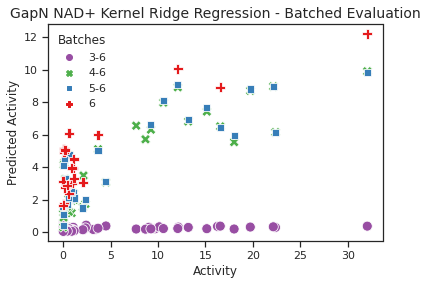

In [209]:
f, ax = plt.subplots()
# color = "#3291a8"
# df2.plot.scatter(x='y', y="y_pred", color=color, ax=ax)
palette = sns.color_palette('Set1')[:df2['Batches'].nunique()][::-1]
markers = ['<','o','x','+','s','*']
sns.scatterplot(data=df2, x='y', y='y_pred', 
                hue='Batches', style='Batches',
                palette=palette,
                s=100,
               )
# if alg == "krr":
#     plt.suptitle(f"GapN NAD+ Kernel Ridge Regression (kernel={kernel}, alpha={best_alpha})", fontsize=14)
# elif alg == "ridge":
#     plt.suptitle(f"GapN NAD+ Ridge Regression", fontsize=14)
# elif alg == "nn":
#     plt.suptitle(f"GapN NAD+ Neural Network", fontsize=14)
# ax.set_title(f"Batched Evaluation - ESM model: {model_name}", fontsize=12)
ax.set_title(f"GapN NAD+ Kernel Ridge Regression - Batched Evaluation", fontsize=14)

ax.set_ylabel("Predicted Activity")
ax.set_xlabel("Activity")

# out_file = f"viz/20211018/batch-eval-gapn-nadh-{alg}-{model_name}-a{best_alpha}.svg"
# print(out_file)
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')